In [1]:
import cv2
import datetime
import networkx as nx
import numpy as np
import math
import osmnx as ox
import pandas as pd

from matplotlib import pyplot as plt

%matplotlib inline

## 入力画像を回転させて計算対象の画像を作成する

In [2]:
def rotate_img(angle, img):
    img_center = (img_w / 2, img_h / 2)
    rotate_matrix = cv2.getRotationMatrix2D(img_center, angle, 1.0)
    
    angle_rad = math.radians(angle)
    rotate_w = math.ceil(img_h * abs(math.sin(angle_rad)) + img_w * abs(math.cos(angle_rad)))
    rotate_h = math.ceil(img_h * abs(math.cos(angle_rad)) + img_w * abs(math.sin(angle_rad)))
    rotate_matrix[0, 2] = rotate_matrix[0, 2] - img_w / 2 + rotate_w / 2
    rotate_matrix[1, 2] = rotate_matrix[1, 2] - img_h / 2 + rotate_h / 2
    
    img_rotate = cv2.warpAffine(img, rotate_matrix, (rotate_w, rotate_h), borderValue=(255, 255, 255))
    return img_rotate

## 画像を読み込んで輪郭を取る

In [3]:
# 輪郭の検出
def find_contours():
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th1 = cv2.threshold(gray_img, 127, 200, cv2.THRESH_BINARY_INV)
    _, contours, _ = cv2.findContours(th1, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    return contours


# 輪郭を近似
def approximate_contours():
    approx_contours = []
    for i, cnt in enumerate(contours):
        arclen = cv2.arcLength(cnt, True)
        if arclen != 0:
            approx_contour = cv2.approxPolyDP(cnt, epsilon=0.01 * arclen, closed=True)
            approx_contours.append(approx_contour)
    return approx_contours

## 太陽高度と方位角を求める

In [4]:
# 後の計算で使うsin, cosの値
def calc_sin_cos():
    date_conv = datetime.datetime.strptime(date, "%Y/%m/%d")
    jan_1 = datetime.datetime(date_conv.year,1,1)
    days = (date_conv - jan_1).days

    theta = 2 * math.pi * (days + 0.5) / 365
    sin = []
    cos = []
    for no in range(1, 4):
        sin.append(math.sin((theta * no)))
        cos.append(math.cos((theta * no)))
    return sin, cos


# 太陽赤緯 declination(°)
def calc_declination():
    sin, cos = calc_sin_cos()
    declination = 0.33281 - 22.984 * cos[0] - 0.34990 * cos[1] - 0.13980 * cos[2] + 3.7872 * sin[0] + 0.03250 * sin[1] + 0.07187 * sin[2]
    return declination


# 時角 t(°)
def calc_hour_angle():
    sin, cos = calc_sin_cos()
    e = 0.0072 * cos[0] - 0.0528 * cos[1] - 0.0012 * cos[2] - 0.1229 * sin[0] - 0.1565 * sin[1] - 0.0041 * sin[2]
    t = (time + (longitude - 135) / 15 + e) * 15 - 180
    return t


# 後の計算で使うradを求めておく
def calc_rad():
    declination = calc_declination()
    t = calc_hour_angle()
    latitude_rad = math.radians(latitude)
    declination_rad = math.radians(declination)
    t_rad = math.radians(t)
    return latitude_rad, declination_rad, t_rad


# 高度 h(rad)
def calc_solar_altitude():
    latitude_rad, declination_rad, t_rad = calc_rad()
    
    sinh = math.sin(latitude_rad) * math.sin(declination_rad) + math.cos(latitude_rad) * math.cos(declination_rad) * math.cos(t_rad)
    h = math.asin(sinh)
    return h


# 方位角 A(rad)
def calc_azimuth():
    latitude_rad, declination_rad, t_rad = calc_rad()
    h = calc_solar_altitude()
    
    sinA = math.cos(declination_rad) * math.sin(t_rad) / math.cos(h)
    cosA = (math.sin(h) * math.sin(latitude_rad) - math.sin(declination_rad)) / math.cos(h) / math.cos(latitude_rad)
    A = math.atan2(sinA, cosA) + math.pi
    return A

## 建物の位置を原点とした時の影の座標

In [5]:
def convert_bldg_h_to_pixel():
    pixel_ver_m = np.shape(model)[1] / map_w
    bldg_h_pixel = bldg_h * pixel_ver_m
    return bldg_h_pixel

In [6]:
def calc_coordinate_of_shade():
    h = calc_solar_altitude()
    A = calc_azimuth()
    
    shade_longth = bldg_h_pixel / math.tan(h)
    shade_x = shade_longth * math.sin(A) * -1
    shade_y = shade_longth * math.cos(A) * -1
    return shade_x, shade_y

## 輪郭から影の位置を求めて影のマスクを作る

In [7]:
def contours_to_list(cnt):
    list_points = []
    for i in range(len(cnt)):
        list_points.append(list(cnt[i][0]))
    return list_points


def df_shade_start_and_end(cnt):
    list_shade_start = contours_to_list(cnt)
    df = pd.DataFrame(list_shade_start)
    df.columns = ["x_start", "y_start"]

    df["x_end"] = df["x_start"] + shade_x
    df["y_end"] = df["y_start"] - shade_y # y軸は画像だと下向きに増えていくので
    return df


def df_to_contours(df):
    list_cnt = []
    for row in df.itertuples():
        list_cnt.append([[row.x_start, row.y_start]])
        list_cnt.append([[row.x_end, row.y_end]])
    cnt = np.array(list_cnt)
    return cnt


def convexhull(df):
    points_cnt = df_to_contours(df).astype("i8")
    hull = cv2.convexHull(np.array(points_cnt))
    return hull


def fill_poly(cnt):
    pts = np.array(contours_to_list(cnt))
    back = np.zeros(np.shape(img))
    fill = cv2.fillPoly(back, [pts], (255,255,255))
    return fill


def make_shade_mask():
    bldg_msk = np.zeros(np.shape(img))
    bldg_and_shade_msk = np.zeros(np.shape(img))
    hull_points = []

    for app_cnt in approx_contours:
        df = df_shade_start_and_end(app_cnt)
        hull = convexhull(df)

        fill_bldg = fill_poly(app_cnt)
        fill_bldg_and_shade = fill_poly(hull)
        bldg_msk = cv2.bitwise_or(bldg_msk, fill_bldg)
        bldg_and_shade_msk = cv2.bitwise_or(bldg_and_shade_msk, fill_bldg_and_shade)
        hull_points.append(hull)

    shade_msk = cv2.bitwise_xor(bldg_msk, bldg_and_shade_msk)
    return shade_msk, hull_points

## 道路と影の重なりを求める

In [8]:
def mask_shade_on_road():
    shade_msk_gray = cv2.cvtColor(shade_msk.astype("u1"), cv2.COLOR_BGR2GRAY)
    road_shade_msk = cv2.bitwise_and(shade_msk_gray, road_img)
    return road_shade_msk

In [9]:
def calc_per_of_shade_on_road():
    road_shade_msk = mask_shade_on_road()
    road_shade_area = len(road_shade_msk[road_shade_msk==200])
    road_shade_per = road_shade_area / road_area
    return road_shade_per

## 影同士を重ねる

In [10]:
def shade_layers():
    shade_color = np.where(shade_msk == 255, 130, shade_msk).astype("u1")
    shade_line = cv2.polylines(shade_layer, hull_points, isClosed=True, color=(255, 255, 255), thickness=1)
    shade_layers = cv2.bitwise_or(shade_layer, shade_color, shade_line)
    return shade_layers

## 影と建物を重ねる

In [11]:
def make_bldg_and_shade():
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_mask = cv2.threshold(img_gray, 210, 255, cv2.THRESH_BINARY_INV)[1]
    bldg_mask = cv2.merge((img_mask, img_mask, img_mask))
    bldg_color = cv2.bitwise_and(img, bldg_mask)

    bldg_and_shade = cv2.bitwise_or(bldg_color, shade_layer)
    bldg_and_shade_back_wh = np.where(bldg_and_shade==0, 255, bldg_and_shade)
    return bldg_and_shade_back_wh

# 実行

In [12]:
# input
date = "2019/6/22"
longitude = 130.41806 # 東経
latitude = 33.60639 # 北緯
bldg_h = 6
map_w = 18

In [13]:
model = cv2.imread("img/model.png")

img_h = np.shape(model)[0]
img_w = np.shape(model)[1]
bldg_h_pixel = convert_bldg_h_to_pixel()

In [14]:
# 道路の角度ごとの影を計算する
time_and_shade = []
for angle in [angle/10 for angle in range(0, 1800, 225)]:
    img = rotate_img(angle, model)

    # 道路部分の面積を求めておく
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    road_img = np.where(gray_img!=200, 0, gray_img)
    road_area = len(road_img[road_img==road_img.max()])

    # 建物の輪郭を取る
    contours = find_contours()
    approx_contours = approximate_contours()

    # 時間ごとの影を求めて重ね書き
    shade_layer = np.zeros(np.shape(img)).astype("u1")
    for time in [i / 100 for i in range(500, 2000, 25)]:
        h = calc_solar_altitude()
        if math.degrees(h) > 0:
            shade_x, shade_y = calc_coordinate_of_shade()
            shade_msk, hull_points = make_shade_mask()
            road_shade_per = calc_per_of_shade_on_road()
            time_and_shade.append([time, road_shade_per, angle])
            shade_layer = shade_layers()

    bldg_and_shade = make_bldg_and_shade()
    cv2.imwrite("output/{}_{}.jpg".format(date.replace("/", ""), angle), bldg_and_shade)

# 影の割合をグラフ化

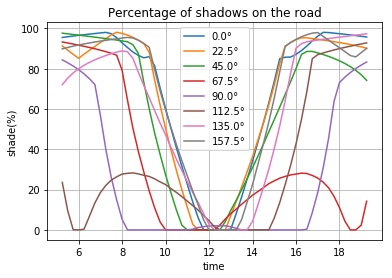

In [16]:
df_time_and_shade = pd.DataFrame(time_and_shade, columns=["time", "shade_per", "angle"])

for angle in np.unique(df_time_and_shade["angle"]):
    df_angle = df_time_and_shade.query("angle == @angle")
    plt.plot(df_angle["time"], df_angle["shade_per"]*100, label=str(angle)+"°")

plt.xlabel("time")
plt.ylabel("shade(%)")
plt.title("Percentage of shadows on the road")
plt.legend()
plt.grid(True)
#plt.savefig("output/graph_{}.png".format(date.replace("/", "")))

# 今回代表地点とした位置から天神駅までの道路の影を調べる

### 経路の情報を得る

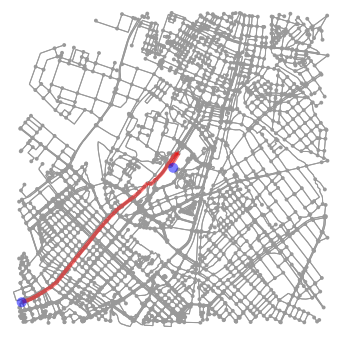

In [17]:
G = ox.graph_from_point((latitude, longitude), distance=1800, network_type="walk")

origin_point = (latitude, longitude)
destination_point = (33.592334, 130.399034) # 天神駅
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)

route = nx.shortest_path(G, origin_node, destination_node, weight="length")
ig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

### 道路の方位と長さを得る

In [18]:
G = ox.add_edge_bearings(G)
bearings = pd.Series(ox.get_route_edge_attributes(G, route, "bearing"))
bearings = pd.Series(np.where(bearings >180, 360 - bearings, 180 - bearings)) # 反時計回りに変換
length = pd.Series(ox.get_route_edge_attributes(G, route, "length"))
bearings_and_len = pd.concat([bearings, length], axis=1)
bearings_and_len.columns = ["bearings", "length"]

### 22.5°刻みの角度に近似し、それごとの総距離の全体に占める割合を集計しておく

In [19]:
bearings_and_len["bearings_about"] = round(bearings_and_len["bearings"] / 22.5) * 22.5
bearings_and_len.loc[bearings_and_len["bearings_about"] == 180, "bearings_about"] = 0
bearings_about_and_len = bearings_and_len.groupby("bearings_about").sum().drop("bearings", axis=1) 
bearings_about_and_len["length_per"] = bearings_about_and_len["length"] / bearings_about_and_len["length"].sum()
bearings_about_and_len

,length,length_per
bearings_about,,
67.5,31.584,0.011457
90.0,45.765,0.016602
112.5,351.638,0.127559
135.0,1954.311,0.708937
157.5,373.379,0.135445


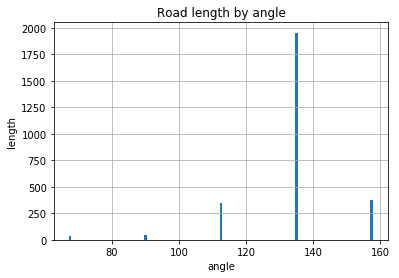

In [20]:
plt.bar(bearings_about_and_len.index, bearings_about_and_len["length"])
plt.xlabel("angle")
plt.ylabel("length")
plt.title("Road length by angle")
plt.grid(True)

### 道路の延長距離で按分し、時間帯ごとの影の割合を計算する

In [21]:
shade_per_length = {}
for time in df_time_and_shade["time"]:
    shade_per = df_time_and_shade.query("time == @time")
    df_calc = pd.merge(shade_per, bearings_about_and_len, left_on="angle", right_on="bearings_about")
    shade_per_length[time] = (df_calc["shade_per"] * df_calc["length_per"]).sum()

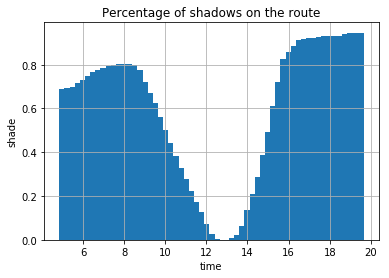

In [22]:
plt.bar(shade_per_length.keys(), shade_per_length.values())
plt.xlabel("time")
plt.ylabel("shade")
plt.title("Percentage of shadows on the route")
plt.grid(True)